In [2]:
import cv2 
import itertools
import numpy as np
from scipy.cluster.vq import kmeans,vq
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import matplotlib as plt
from skimage import color
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("./ImageColorization-master/colorizer/gco_python/")
import pygco

In [203]:
def discretize_color_space(ncolors):
    '''
    Generates a palette, which maps the 8-bit color channels to bins in the discretized space.
    Also generates colors, which is a list of all possible colors (a,b components) in this space.
    '''
    levels = int(np.floor(np.sqrt(ncolors)))
    inds = np.arange(0, 256)
    div = np.linspace(0, 255, levels+1)[1]
    quantiz = np.int0(np.linspace(0, 255, levels))
    color_levels = np.clip(np.int0(inds/div), 0, levels-1)
    palette = quantiz[color_levels]
    bins = np.unique(palette) #the actual color bins
    colors = list(itertools.product(bins, bins)) #find all permutations of a/b bins
    color_to_label_map = {c:i for i,c in enumerate(colors)} #this maps the color pair to the index of the color
    label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys())) #takes a label and returns a,
    return colors, color_to_label_map, label_to_color_map


def train_kmeans(a, b, k):
    pixel = np.squeeze(cv2.merge((a.flatten(),b.flatten()))).astype(float)
    centroids= kmeans(pixel,k) 
    return centroids[0].shape[0]


# K-means Color Space and Centroids
def quantize_kmeans(a, b,ncolors, npics):
    lengthab = len(a) / npics
    
#     w,h = np.shape(a)
        
    # reshape matrix
    pixel = np.reshape((cv2.merge((a,b))),(len(a),2)).astype(float)
    
    # quantization
    kmeans = KMeans(n_clusters=ncolors) 
    label=kmeans.fit(pixel)
    return label.labels_.reshape(int(np.sqrt(int(lengthab))),int(np.sqrt(int(lengthab))),int(npics))

# def label_to_color_map_fun(a,b,ncolors):
#     w,h = np.shape(a)
#     pixel = np.reshape((cv2.merge((a,b))),(w * h),2).astype(float)
#     centroids,_ = kmeans(pixel,ncolors)

#     color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in centroids])}
#     label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
#     return label_to_color_map

def label_to_color_map_fun(a,b,ncolors):
#     w,h = np.shape(a)
    pixel = np.reshape((cv2.merge((a,b))),(len(a),2)).astype(float)
    centroids,_ = kmeans(pixel,ncolors)

    color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in centroids])}
    label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
    return label_to_color_map

In [196]:
# from skimage import color 
def load_image(path):
    '''
    Read in a file and separate into L*a*b* channels
    '''
    #read in original image
    img = cv2.imread(path) 
    #convert to L*a*b* space and split into channels
    l, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2LAB))
    return l, a, b

In [197]:
print(np.max(l),np.min(l))
print(np.max(a),np.min(a))
print(np.max(b),np.min(b))

255 2
160 98
140 62


In [198]:
def posterize(a, b,ncolors):
    
    levels = int(np.floor(np.sqrt(ncolors)))
    inds = np.arange(0, 256)
    div = np.linspace(0, 255, levels+1)[1]
    quantiz = np.int0(np.linspace(0, 255, levels))
    color_levels = np.clip(np.int0(inds/div), 0, levels-1)
    palette = quantiz[color_levels]
    bins = np.unique(palette) #the actual color bins
    colors = list(itertools.product(bins, bins)) #find all permutations of a/b bins
    #this maps the color pair to the index of the color
    color_to_label_map={c:i for i,c in enumerate(colors)}
    label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
    a_quant = cv2.convertScaleAbs(palette[a])
    b_quant = cv2.convertScaleAbs(palette[b])
    return a_quant, b_quant,palette,color_to_label_map,label_to_color_map 

In [199]:
def train_svm(l,a,b,ntrain,ncolors,prob,gamma,cost,npca):
    
    #dimensions of image
    m,n = l.shape 
    features = []
    classes = []
    numTrainingExamples = 0
    colors_present = []
    svm = [SVC(probability=prob, gamma=gamma, C=cost) for i in range(ncolors)]
    pca = PCA(npca)
    
    scaler = preprocessing.MinMaxScaler() 
    
    label=quantize_kmeans(a, b,ncolors)
    
    for i in range(ntrain):
        #choose random pixel in training image
        x = int(np.random.uniform(n))
        y = int(np.random.uniform(m))
        
        features.append(get_features(l, (x,y)))
        classes.append(label[x,y])
        numTrainingExamples = numTrainingExamples + 1
        
    # normalize columns
    features =scaler.fit_transform(np.array(features))
    classes = np.array(classes)
        
       
    # reduce dimensionality
    features = pca.fit_transform(features)
    
    for i in range(ncolors):
        if len(np.where(classes==i)[0])>0:
            curr_class = (classes==i).astype(np.int32)
            colors_present.append(i)
            svm[i].fit(features,(classes==i).astype(np.int32))
            
    return colors_present,svm

In [200]:
def train_svm_new(files,ntrain,ncolors,prob,gamma,cost,npca):
    
    #dimensions of image
    l,a,b = load_image(files[0])
    m,n = l.shape 
    features = []
    classes = []
    numTrainingExamples = 0
    colors_present = []
    svm = [SVC(probability=prob, gamma=gamma, C=cost) for i in range(ncolors)]
    pca = PCA(npca)
    
    scaler = preprocessing.MinMaxScaler() 
    npics = len(files)
    kmap_a = np.array([])
    kmap_b = np.array([])
    for f in files:

        _,a,b = load_image(f)
        kmap_a = np.concatenate([kmap_a, a.flatten()])
        kmap_b = np.concatenate([kmap_b, b.flatten()])

    label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)  #get labels for files 
    
    for ind, f in enumerate(files):
        l,a,b = load_image(f)  
#         a,b = quantize_kmeans(a,b, ncolors, 1)
        
        for i in range(ntrain):
        #choose random pixel in training image
            x = int(np.random.uniform(n))
            y = int(np.random.uniform(m))
        
            features.append(get_features(l, (x,y)))
            classes.append(label[x,y,ind])
            numTrainingExamples = numTrainingExamples + 1
        
    # normalize columns
    features =np.array(features)
    classes = np.array(classes)
        
       
    # reduce dimensionality
    #features = pca.fit_transform(features)
    
    for i in range(ncolors):
        if len(np.where(classes==i)[0])>0:
            curr_class = (classes==i).astype(np.int32)
            colors_present.append(i)
            svm[i].fit(features,(classes==i).astype(np.int32))
            
    return colors_present,svm

In [201]:
def feature_surf(img, pos):
    '''
    Gets the SURF descriptor of img at pos = (x,y).
    Assume img is a single channel image.
    '''
    octave2 = cv2.GaussianBlur(img, (0, 0), 1)
    octave3 = cv2.GaussianBlur(img, (0, 0), 2)
    kp = cv2.KeyPoint(pos[0], pos[1], SURF_WINDOW)
    surf = cv2.xfeatures2d.SURF_create()
    _, des1 = surf.compute(img, [kp])
    _, des2 = surf.compute(octave2, [kp])
    _, des3 = surf.compute(octave3, [kp])
    return np.concatenate((des1[0], des2[0], des3[0]))

def feature_dft(img, pos):
    xlim = (max(pos[0] - windowSize,0), min(pos[0] + windowSize,img.shape[1]))
    ylim = (max(pos[1] - windowSize,0), min(pos[1] + windowSize,img.shape[0]))
    patch = img[ylim[0]:ylim[1],xlim[0]:xlim[1]]
        
    l = (2*windowSize + 1)**2
    
    #return all zeros for now if we're at the edge
    if patch.shape[0]*patch.shape[1] != l:
        return np.zeros(l)
    return np.abs(np.fft(patch.flatten()))


def feature_position(img, pos):
    m,n = img.shape
    x_pos = pos[0]/n
    y_pos = pos[1]/m
    
    return np.array([x_pos, y_pos])
            

def get_features(img, pos):
    intensity = np.array([img[pos[1], pos[0]]])
    #position = feature_position(img, pos)
    meanvar = np.array([getMean(img, pos), getVariance(img, pos)])
    feat = np.concatenate((meanvar, feature_surf(img, pos), feature_dft(img, pos)))
    return feat


def getMean(img, pos):
    ''' 
    Returns mean value over a windowed region around (x,y)
    '''
     
    xlim = (max(pos[0] - windowSize,0), min(pos[0] + windowSize,img.shape[1]))
    ylim = (max(pos[1] - windowSize,0), min(pos[1] + windowSize,img.shape[0]))
    return np.mean(img[ylim[0]:ylim[1],xlim[0]:xlim[1]])

        
def getVariance(img, pos):
    
    xlim = (max(pos[0] - windowSize,0), min(pos[0] + windowSize,img.shape[1]))
    ylim = (max(pos[1] - windowSize,0), min(pos[1] + windowSize,img.shape[0]))
    
    return np.var(img[ylim[0]:ylim[1],xlim[0]:xlim[1]])/1000

# add
def get_edges(img, blur_width=3):
        img_blurred = cv2.GaussianBlur(img, (0, 0), blur_width)
        vh = cv2.Sobel(img_blurred, -1, 1, 0)
        vv = cv2.Sobel(img_blurred, -1, 0, 1)

        #vh = vh/np.max(vh)
        #vv = vv/np.max(vv)
        
        #v = np.sqrt(vv**2 + vh**2)

        v = 0.5*vv + 0.5*vh
#        print('max pre-normalize: %f'%np.amax(v))
        #v = v/np.amax(v)
        return v


In [269]:
train_dir = ['./data/' + str(num).zfill(4) + '.jpg' for num in range(1,6)]
train_dir

['./data/0001.jpg',
 './data/0002.jpg',
 './data/0003.jpg',
 './data/0004.jpg',
 './data/0005.jpg']

In [ ]:
ncolors = 16
ntrain = 8000
# (l, a, b) = load_image(img)
prob = False
npca = 635
gamma = 0.1
cost = 5.0
colors_present,svm = train_svm_new(train_dir,
                           ntrain = ntrain,
                           ncolors = ncolors,
                           prob = prob,
                           gamma = gamma,
                           cost = cost,
                           npca = npca)


327680
1


In [254]:
l, a, b = load_image(img)
print(l.shape,a.shape,b.shape)
# label_kmeans = quantize_kmeans(a, b, ncolors)

(720, 720) (720, 720) (720, 720)


In [230]:
def get_lab(files):
    
    kmap_a = np.array([])
    kmap_b = np.array([])
    kmap_l = np.array([])
    for f in files:
        l,a,b = load_image(f)
        kmap_l = np.concatenate([kmap_l, l.flatten()])
        kmap_a = np.concatenate([kmap_a, a.flatten()])
        kmap_b = np.concatenate([kmap_b, b.flatten()])
    return kmap_l, kmap_a, kmap_b

In [231]:
l,a,b = get_lab(train_dir)
# print(len(a))
label_to_color_map = label_to_color_map_fun(a,b,ncolors)
label_to_color_map.keys()
print(len(label_to_color_map.keys()))
# col_tmp = []
# for i in predict0:
# #     i
#     col_tmp.append(label_to_color_map[i])
# # col_tmp
for i in label_to_color_map.keys():
    print(label_to_color_map[i])

16
(127.81590172325542, 127.94564067565261)
(136.69735960327034, 88.20479828441228)
(124.94564746643569, 123.4099177132958)
(110.36012640835395, 107.04863973619126)
(124.94773629864972, 85.82565528196982)
(128.44387001477105, 107.49236829148202)
(128.7953701057445, 90.04372677907973)
(134.42289899768696, 97.47378565921358)
(141.8812292358804, 82.55502491694352)
(120.3939184519696, 89.52392881824464)
(124.0418045112782, 97.54255639097744)
(114.15340464388208, 113.46230106965822)
(113.6311515348384, 94.36300146175086)
(125.01527024311835, 116.86638537271449)
(134.0011517420098, 80.69809962568385)
(129.718472617652, 84.0468095796349)


In [265]:
label_to_color_map[1] = (32,32)
label_to_color_map[2] = (96,32)
label_to_color_map[3] = (160,32)
label_to_color_map[4] = (224,32)
label_to_color_map[5] = (32,96)
label_to_color_map[6] = (96,96)
label_to_color_map[7] = (160,96)
label_to_color_map[8] = (224,96)
label_to_color_map[9] = (32,160)
label_to_color_map[10] = (96,160)
label_to_color_map[11] = (160,160)
label_to_color_map[12] = (224,160)
label_to_color_map[13] = (32,224)
label_to_color_map[14] = (96,224)
label_to_color_map[15] = (160,224)
label_to_color_map[0] = (224,224)

# graph cut

In [257]:
def graphcut(colors_present, label_to_color_map, label_costs, g, l=100):
    
    num_classes = len(colors_present)

    #calculate pariwise potiential costs (distance between color classes)
    pairwise_costs = np.zeros((num_classes, num_classes))
    for ii in range(num_classes):
        for jj in range(num_classes):
            c1 = np.array(label_to_color_map[ii])
            c2 = np.array(label_to_color_map[jj])
            pairwise_costs[ii,jj] = np.linalg.norm(c1-c2)

    label_costs_int32 = (100*label_costs).astype('int32')
    pairwise_costs_int32 = (l*pairwise_costs).astype('int32')
    vv_int32 = g.astype('int32')
    vh_int32 = g.astype('int32')

    #vv_int32 = (1/np.clip(self.g,0.00001,10000)).astype('int32')
    #vh_int32 = (1/np.clip(self.g,0.00001,10000)).astype('int32')

    #perform graphcut optimization
    new_labels = pygco.cut_simple_vh(label_costs_int32,
                                     pairwise_costs_int32,
                                     vv_int32, vh_int32,
                                     n_iter=10, algorithm='swap') 

    #new_labels = pygco.cut_simple(label_costs_int32, pairwise_costs_int32, algorithm='swap')

    return new_labels

# colorize

In [258]:
def colorize(colors_present,label_to_color_map, img, svm, skip=4, SAVE_OUTPUTS = False):
    '''
    -- colorizes a grayscale image, using the set of SVMs defined by train().

    Returns:
    -- ndarray(m,n,3): a mxn pixel RGB image
    ''' 
    scaler = preprocessing.MinMaxScaler()   
    m,n = img.shape

    num_classified = 0
    _,raw_output_a,raw_output_b = cv2.split(cv2.cvtColor(cv2.merge((img, img, img)), 
                                                         cv2.COLOR_RGB2LAB))

#     raw_output_a,_,raw_output_b = cv2.split(cv2.cvtColor(cv2.merge((img, img, img)), 
#                                                          cv2.COLOR_RGB2HLS))
#     _,raw_output_a,raw_output_b = cv2.split(cv2.cvtColor(cv2.merge((img, img, img)), cv.CV_RGB2Lab)) 
    #default a and b for a grayscale image

    output_a = np.zeros(raw_output_a.shape)
    output_b = np.zeros(raw_output_b.shape)

    num_classes = len(colors_present)
    label_costs = np.zeros((m,n,num_classes))

    g = np.zeros(raw_output_a.shape)

    count=0
    for x in np.arange(0,n,skip):
        for y in np.arange(0,m,skip):
            
            feat = get_features(img, (x,y)).reshape(1,-1)
#             feat = scaler.fit_transform(get_features(img, (x,y)).reshape(-1,1).reshape(1,-1))
#             feat = scaler.fit_transform(np.array(tmp).reshape(-1,1),y= np.array([0,1]))
#             print(len(feat))

            #print "Size, Pre-PCA"
            #print np.shape(feat)
#             pca = PCA(npca)
#             feat = pca.fit_transform(feat)
            #print "size, Post-PCA"
            #print np.shape(feat)

            #sys.stdout.write('\rcolorizing: %3.3f%%'%(np.min([100, 100*count*skip**2/(m*n)])))
            #sys.stdout.flush()
            count += 1

            # Hard-but-correct way to get g
            # self.g[y-int(skip/2):y+int(skip/2)+1,x-int(skip/2):x+int(skip/2)+1] = self.color_variation(feat)

            #get margins to estimate confidence for each class
            for i in range(num_classes):
                cost = -1*svm[colors_present[i]].decision_function(feat)[0]
                label_costs[y-int(skip/2):y+int(skip/2)+1,x-int(skip/2):x+int(skip/2)+1,i] = cost
    #edges = self.get_edges(img)
    #self.g = np.sqrt(edges[0]**2 + edges[1]**2)
    g = get_edges(img)
    #self.g = np.log10(self.g)

    if SAVE_OUTPUTS:
        #dump to pickle
        print('saving to dump.dat')
        fid = open('dump.dat', 'wb') 
        pickle.dump({'S': label_costs, 'g': g, 'cmap': label_to_color_map,
                     'colors': colors_present}, fid)
        fid.close()

    # postprocess using graphcut optimization 
#     output_labels = graphcut(label_costs, l=graphcut_lambda)
    output_labels = graphcut(colors_present, label_to_color_map, label_costs, g, l=100)
    

    
    for i in range(m):
        for j in range(n):

            a,b = label_to_color_map[colors_present[output_labels[i,j]]]

            output_a[i,j] = a
            output_b[i,j] = b
            
    output_img = cv2.cvtColor(cv2.merge(( img,np.uint8(output_a), np.uint8(output_b))), cv2.COLOR_LAB2RGB)

    return output_img, g, output_labels

In [259]:
label_to_color_map

{0: (127.81590172325542, 127.94564067565261),
 1: (136.69735960327034, 88.20479828441228),
 2: (124.94564746643569, 123.4099177132958),
 3: (110.36012640835395, 107.04863973619126),
 4: (124.94773629864972, 85.82565528196982),
 5: (128.44387001477105, 107.49236829148202),
 6: (128.7953701057445, 90.04372677907973),
 7: (134.42289899768696, 97.47378565921358),
 8: (141.8812292358804, 82.55502491694352),
 9: (120.3939184519696, 89.52392881824464),
 10: (124.0418045112782, 97.54255639097744),
 11: (114.15340464388208, 113.46230106965822),
 12: (113.6311515348384, 94.36300146175086),
 13: (125.01527024311835, 116.86638537271449),
 14: (134.0011517420098, 80.69809962568385),
 15: (129.718472617652, 84.0468095796349)}

In [264]:
count = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0,16:0}
for i in color_tmp[2]:
    for j in i:
        if j >0:
            count[j]+=1
# sum(count.values())/256/256
count

{1: 649,
 2: 54579,
 3: 683,
 4: 1909,
 5: 330,
 6: 310,
 7: 282,
 8: 181,
 9: 518,
 10: 206,
 11: 460,
 12: 194,
 13: 362,
 14: 481,
 15: 337,
 16: 0}

In [266]:
# img_file = cv2.imread(img)
# img_file = load_image(img)[0]
# get_edges(img_file)
# img_test = './Train/test.jpg'
img_test = './data/0003.jpg'
# l a b
img_test_file = load_image(img_test)
# img_test_file = cv2.imread(img_test) 
color_tmp = colorize(colors_present,label_to_color_map, img = img_test_file[0], svm = svm, skip=16)

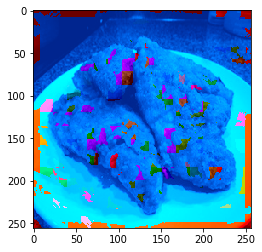

In [267]:
plt.imshow(color_tmp[0])
plt.show()
plt.imsave('color_tmp.jpg',color_tmp[0])
# plt.imshow(load_image_gray(img_test)[0])
# plt.show()

In [50]:
# img_test_file.shape
img_test = './Train/test.jpg'
# img_test_file = load_image(img_test)[0]
img_test_file = cv2.imread(img_test)
print(img_test_file.shape)

(256, 256, 3)


In [81]:
print(color_tmp[0].max(),color_tmp[0].min())
# gb = lab2rgb(color_tmp[0])*160/2
# gb = (color_tmp[0] + [0, 128, 128]) / [100, 255,255]
gb = cv2.cvtColor( color_tmp[0], cv2.COLOR_Lab2RGB)
print(gb.max(),gb.min())


255 1
255 0


In [82]:
color_tmp[2].shape

(256, 256)

In [83]:
print(np.min(color_tmp[2]),np.max(color_tmp[2]))
gb = color_tmp[0]

0 7


(256, 256, 3)


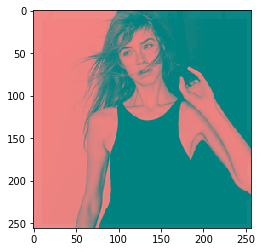

In [43]:
print(gb.shape)
plt.imsave('gb.jpg't,gb)
# gb[:,:,:] -= 40
plt.imshow(gb)
plt.show()
# print(1)
# plt.imshow(img_test_file)
# plt.show()
# img_test_file_grey = img_test_file[:,:,0]
# print(img_test_file_grey.shape)

# img_test_file_grey[:,:] = 0
# # img_test_file_grey[1] = 0
# plt.imsave('gb.jpg',gb)
# plt.imshow(img_test_file_grey)
# plt.show()
# img_test_file_grey.shape

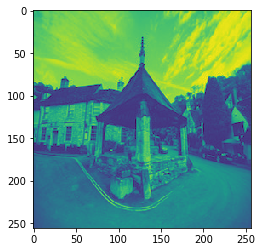

In [116]:
test_grey = cv2.cvtColor( img_test_file, cv2.COLOR_LAB2RGB)
test_grey = cv2.cvtColor( test_grey, cv2.COLOR_RGB2GRAY)
plt.imshow(test_grey)
plt.imsave('test_grey.jpg',test_grey)
import matplotlib.image as mpimg
img_test=mpimg.imread('./Train/test.jpg')
lum_img = np.copy(img_test)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
lum_img = rgb2gray(lum_img)
plt.imshow(lum_img[:,:])

## EDA

In [46]:
from numpy import array
from scipy.cluster.vq import vq
code_book = array([[1.,2.,3.,4.]])
features  = array([[1.5,2.5,3.5,4.5]])
vq(features,code_book)

(array([0], dtype=int32), array([1.]))

In [1]:
img_test_tmp = get_edges(img_test_file)
img_test_tmp.shape